In [1]:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [3]:
model = torch.load('/Users/stephandekker/workspace/pink_lady/storage/data/generated/20230616-115501_pinky_loss.pt')

In [34]:
image_url = '/Users/stephandekker/workspace/pink_lady/storage/images/apple360/Test/eggplant_violet_1/r0_11.jpg'
img = cv2.imread(image_url)

In [35]:
print(image_url)

/Users/stephandekker/workspace/pink_lady/storage/images/apple360/Test/eggplant_violet_1/r0_11.jpg


In [36]:
if img is None:
    print("Error: Failed to convert the image to RGB.")

In [37]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.6453, 0.4631, 0.3085], std=[0.2000, 0.2238, 0.2254])


In [38]:
# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Ensure that the model's weight tensor is on the same device as the input tensor
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

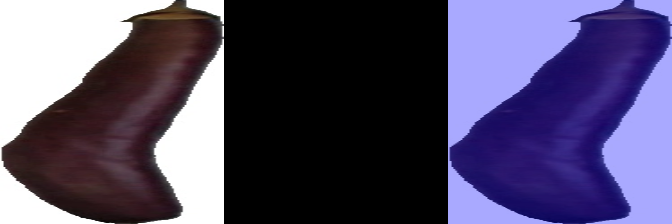

In [39]:
# As usual for classication, the target is the logit output
# before softmax, for that category.
target_layers = [model.layer4[-1]] #Resnet18 and 50: model.layer4[-1], from gradcam github documentation
targets = [ClassifierOutputTarget(3)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [40]:
import torch
from PIL import Image
import torchvision.transforms as T
# Load the model and set the device


# Load and preprocess the image

transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = Image.open(image_url)
image = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image tensor to the device
image = image.to(device)

# Forward pass through the model
model.eval()
with torch.no_grad():
    output = model(image)

# Get the predicted class
_, predicted = torch.max(output, 1)
predicted_class_index = predicted.item()

# Get the class label from the index using the labels dictionary
dataset_path = "/Users/stephandekker/workspace/pink_lady/storage/images/apple360/Test"
dataset = ImageFolder(dataset_path, transform=transform)
retreived_dict = dataset.class_to_idx
# print(retreived_dict)

labels_dict = {value: key for key, value in retreived_dict.items()}
# print(labels_dict)
predicted_class = labels_dict[predicted_class_index]

print("Predicted class:", predicted_class)



Predicted class: eggplant_violet_1
